# Reproduction of the results from the paper using the Runge-Kutta method 
The following code is based on the article "A Mathematical Model of Skeletal Muscle Disease and Immune Response in the mdx Mouse", written by Jarrah et al. and published in 2014. The values chosen for the parameters are the ones estimated in the paper. The trajectories follow a similar pattern as the ones in the paper, but they are not exactly the same. This is probably due to a different initialisation.

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from functools import partial
import configparser

### Original system of equations

In [3]:
def DMD_model(t, state_variables, initial_conditions, parameters, damage_par):

    H, C, M, N, D, R = state_variables
    H_i, C_i, M_i, N_i, D_i, R_i = initial_conditions
    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D = parameters
    
    dHdt=ev_H(H, M, D, H_i, k1, d_H)
    dCdt=ev_C(H, C, D, C_i, k2, d_C)
    dMdt=ev_M(M, D, M_i, k3, d_M)
    dNdt=ev_N(t, C, N, R, R_i, k4, k5, damage_par)
    dDdt=ev_D(t, C, M, N, D, D_i, k5, k6, d_D, damage_par)
    dRdt=ev_R(M, D, R, R_i, k4, k6, d_D)

    return [dHdt, dCdt, dMdt, dNdt, dDdt, dRdt]


def ev_H(H, M, D, H_i, k1, d_H):
    b_H = d_H * H_i
    return b_H + k1 * M * D - d_H * H

def ev_C(H, C, D, C_i, k2, d_C):
    b_C = d_C * C_i
    return b_C + k2 * H * D - d_C * C
    
def ev_M(M, D, M_i, k3, d_M):
    b_M = d_M * M_i
    return b_M + k3 * M * D - d_M * M

def ev_N(t, C, N, R, R_i, k4, k5, damage_par):
    return k4 * R - k5 * C * N - damage(t, damage_par) * N
    
def ev_D(t, C, M, N, D, D_i, k5, k6, d_D, damage_par):

    return k5 * C * N + damage(t, damage_par) * N - k6 * D * M - d_D * D

def ev_R( M, D, R, R_i, k4, k6, d_D):

    return k6 * D * M + d_D * D - k4 * R   

### Damage function

In [4]:
def damage(t, damage_par):

    sigma, m, h = damage_par
    if t==0 or t <=1e-10:
        return 0.

    else:
        return h / (t * sigma * np.sqrt(2*np.pi)) * np.exp(-(np.log(t) - m)**2 / (2. * sigma**2))

### Function to retrieve information from the configuration file

In [6]:
def extract_values(section_name, config):
    values = []
    if section_name in config:
        for key, value in config[section_name].items():
            values.append(float(value))
    else:
        print(f'Section "{section_name}" is not in the configuration file')
    return values

### Simulation

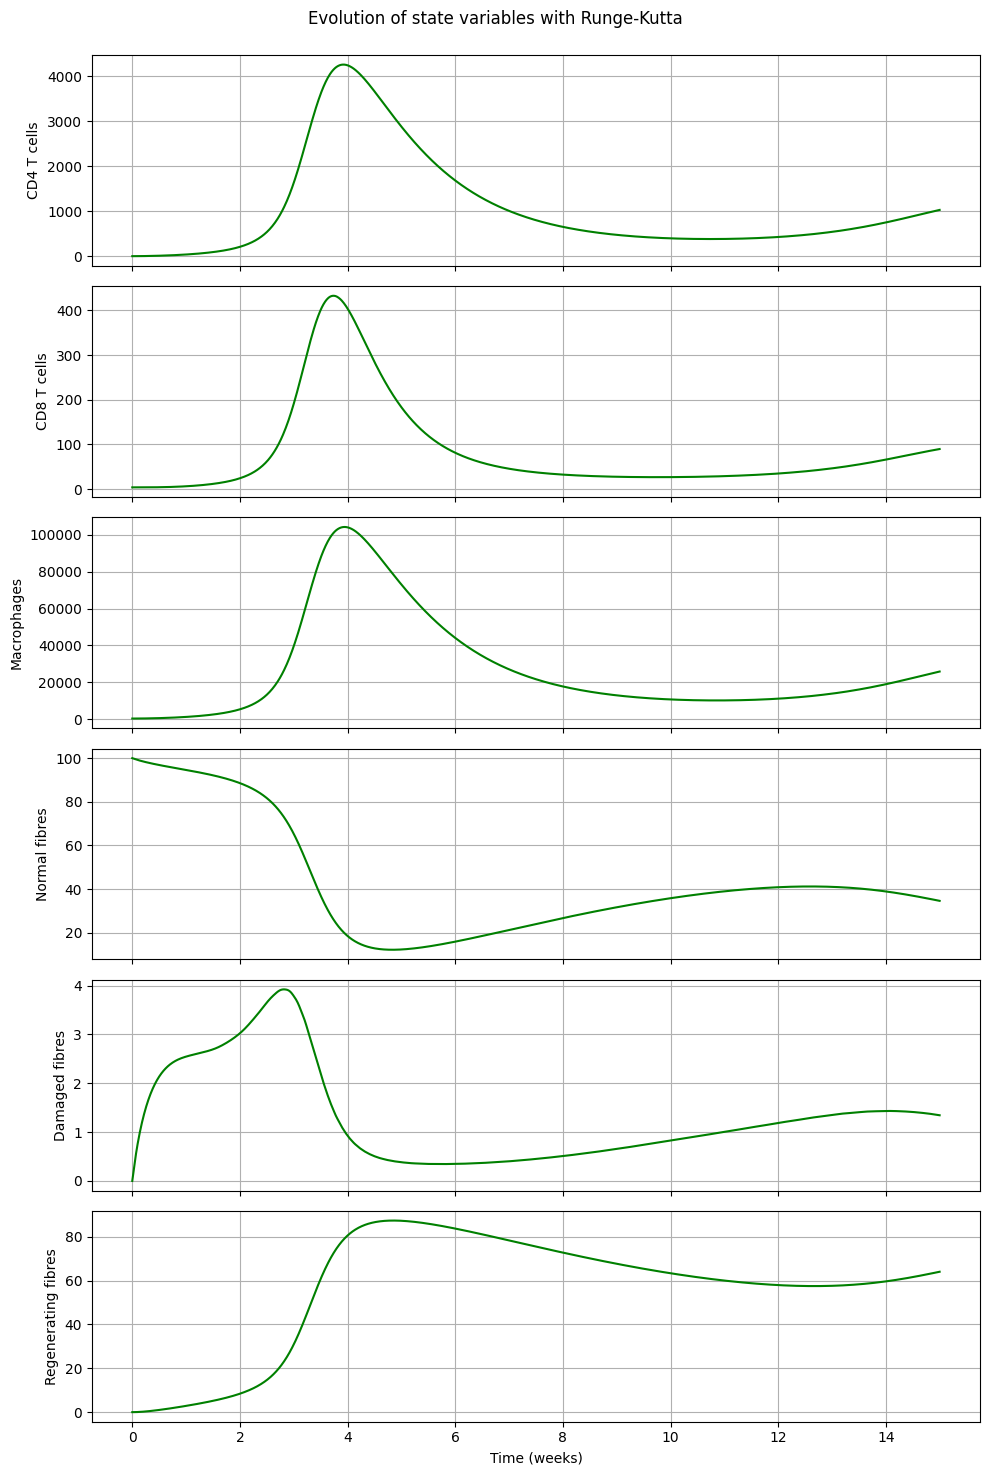

In [8]:
#Extract the needed parameters from the configuration file
config = configparser.ConfigParser()
config.read('config_RK.ini')

initial_conditions = extract_values('initial_conditions', config)
parameters = extract_values('parameters', config)
damage_par = extract_values('damage_parameters', config)
time_par = extract_values('time_par', config)
t_min, t_max = time_par

t_span = (int(t_min), int(t_max))
t_eval = np.linspace(int(t_min), int(t_max), int((t_max - t_min)*100))

#Use partial function to include initial conditions and solve with Runge Kutta 4
DMD_model_ic = partial(DMD_model, initial_conditions = initial_conditions, parameters=parameters, damage_par = damage_par)
solution = solve_ivp(DMD_model_ic, t_span, initial_conditions, method='RK45', t_eval=t_eval)

#Extract values
t_values = solution.t
values = solution.y

n_vars = values.shape[0]
labels = ["CD4 T cells", "CD8 T cells", "Macrophages", "Normal fibres", "Damaged fibres", "Regenerating fibres"]

fig, axes = plt.subplots(n_vars, 1, figsize=(10, 15), sharex=True)

#Plot each state variable in a separate subplot
for i in range(n_vars):
    axes[i].plot(t_values, values[i], label=labels[i], color='green')
    axes[i].set_ylabel(labels[i])
    #axes[i].legend()
    axes[i].grid(True)

axes[-1].set_xlabel('Time (weeks)')

fig.suptitle('Evolution of state variables with Runge-Kutta')

plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig(f"paper_reproduction_RK4.png")

plt.show()